<a href="https://colab.research.google.com/github/XueyanZhang/MachineLearningCompilation/blob/master/6_Integration_with_ML_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integration with Machine Learning Frameworks

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 MB 13.5 MB/s eta 0:00:00


# Build IRModule via Builder

past IRModules was written mannual in TVMScript.

it doesn't meet the demand for large systems.

need a way to construct IRModule programmatically.

## Tensor Expression

Tensor Expression for TensorIR Creation

In [2]:
from tvm import te

# create input
f32 = "float32"
A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")
print(type(A))
print(A.shape)

<class 'tvm.te.tensor.Tensor'>
[128, 128]


In [3]:
# define computation
def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    m = A.shape[0]
    n = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name='k')
    return te.compute((m, n), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

In [4]:
# create result
C = te_matmul(A, B)
print(C)


Tensor(shape=[128, 128], op.name=matmul)


In [5]:
# create TensorIR function
te.create_prim_func([A, B, C]).show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [6]:
# create relu func
def te_relu(A: te.Tensor) -> te.Tensor:
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")

the `*i` represents arbitrary shape index. here are some examples:

In [7]:
# 1D input
X1 = te.placeholder((10, ), dtype=f32, name='X1')
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1])

# from tvm.script import tir as T

@T.prim_func
def main(X1: T.Buffer((10,), "float32"), relu: T.Buffer((10,), "float32")):
    T.func_attr({"global_symbol": "main", "tir.noalias": T.bool(True)})
    # with T.block("root"):
    for i0 in range(10):
        with T.block("relu"):
            v_i0 = T.axis.spatial(10, i0)
            T.reads(X1[v_i0])
            T.writes(relu[v_i0])
            relu[v_i0] = T.max(X1[v_i0], T.float32(0))

In [8]:
# 2D input
X2 = te.placeholder((10, 10), dtype=f32, name='X2')
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2])

# from tvm.script import tir as T

@T.prim_func
def main(X2: T.Buffer((10, 10), "float32"), relu: T.Buffer((10, 10), "float32")):
    T.func_attr({"global_symbol": "main", "tir.noalias": T.bool(True)})
    # with T.block("root"):
    for i0, i1 in T.grid(10, 10):
        with T.block("relu"):
            v_i0, v_i1 = T.axis.remap("SS", [i0, i1])
            T.reads(X2[v_i0, v_i1])
            T.writes(relu[v_i0, v_i1])
            relu[v_i0, v_i1] = T.max(X2[v_i0, v_i1], T.float32(0))

## fuse / fusion 

In [9]:
# fuse matmul w/ relu
C = te_matmul(A, B)
D = te_relu(C)

te.create_prim_func([A, B, D]).show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


note only A B D are passed in, and C omitted.

above, we can see prim func create temp buffer for C/matmul.

we can still pass in C. however, the fusion is less advanced.

In [10]:
te.create_prim_func([A, B, C, D]).show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


note how C/matmul is passed in.

# Connect IRModules via BlockBuilder 

build end to end model with IRModule defined above

In [11]:
# define input
A = relax.Var("A", relax.TensorStructInfo((128, 128), f32))
B = relax.Var("B", relax.TensorStructInfo((128, 128), f32))

# create block builder
bb = relax.BlockBuilder()

with bb.function("main"):
    with bb.dataflow():
        C = bb.emit_te(te_matmul, A, B)
        D = bb.emit_te(te_relu, C)
        R = bb.emit_output(D)
    bb.emit_func_output(R, params=[A, B])

# show IRModule
MyModule = bb.get()
print(type(MyModule))
MyModule.show()

<class 'tvm.ir.module.IRModule'>


/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


compare this model to the end-to-end model in last notebook:

- pretty much the same
- much less code wrote to achieve

# Import model from PyTorch

now we know how to construct an IRModule programmatically.

lets convert a PyTorch model into IRModule format.

In [12]:
# define the PyTorch model (and convert it to IRModule)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(128, 128))

    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x

### TorchFX

to trace a graph of PyTorch model.  
(util tool to visualize model)

In [13]:
model = MyModel()
fx_module = fx.symbolic_trace(model)
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7f751658e880>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7f751658e880>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


In [14]:
for node in fx_module.graph.nodes:
    print(node.op)

placeholder
get_attr
call_function
call_function
output


## Create Map Func

workflow:
1. create `node_map` to map `fx.Node` to `relax.Var`
2. iterate over nodes in `fx.graph` in topological order
3. compute mapped output

In [18]:
def map_param(param: nn.Parameter):
    """helper func"""
    ndim = len(param.data.shape)
    return relax.const(
        param.data.cpu().numpy(), relax.DynTensorType(ndim, "float32")
    )

def fetch_attr(fx_mod, target: str):
    """helper func"""
    target_atoms = target.split('.')
    attr_itr = fx_mod
    for i, atom, in enumerate(target_atoms):
        if not hasattr(attr_itr, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_itr = getattr(attr_itr, atom)
    return attr_itr

def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())

    bb = relax.BlockBuilder()

    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            for node in fx_mod.graph.nodes:
                if node.op == 'placeholder': # found input vars
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(
                        node.target, relax.TensorStructInfo(shape, f32)
                    )
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == 'get_attr': # found parameters
                    attr = fetch_attr(fx_mod, node.target)
                    param = map_param(attr)
                    node_map[node] = param
                elif node.op == 'call_function': # found a func
                    func = call_function_map[node.target](bb, node_map, node)
                    node_map[node] = func
                elif node.op == 'call_module': # this one D.N.E in our example
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == 'output': # found output
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        bb.emit_func_output(fn_output, fn_inputs)
    return bb.get()



In [16]:
# supply translation rule via map
def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

In [17]:
# create IRModule
MyModule = from_fx(
    fx_module,
    input_shapes = [(1, 128)],
    call_function_map = {
      torch.matmul: map_matmul,
      torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


# FashionMNIST example

rewrite end to end model, FashionMNIST, using te and blockbuilder.

In [20]:
import torch
import torchvision

# load data
test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img, label = next(iter(test_loader))
print(img.shape)
img = img.reshape(1, 28, 28).numpy()

100%|██████████| 26421880/26421880 [00:01<00:00, 17157771.94it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302138.44it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5525780.11it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17301504.00it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

torch.Size([1, 1, 28, 28])


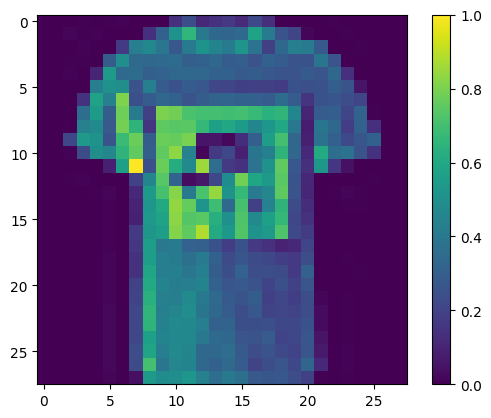

class: T-shirt/top


In [21]:
# plot img
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("class:", class_names[label[0]])

In [28]:
# download trained parameters
import pickle as pkl

!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

File ‘fasionmnist_mlp_params.pkl’ already there; not retrieving.



In [31]:
# MLP model in pytorch (which will be converted to TensorIR Module)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

In [35]:
# init mlp w/ param
mlp_model = MLP()
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params["b1"])

torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("torch prediction", class_names[pred_kind[0]])
# success prediction

torch prediction T-shirt/top


## Translate to IRModule

In [36]:
from tvm import topi

def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit_te(topi.nn.dense, x, w)
    z = bb.emit_te(topi.add, y, b)
    return z

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)

# reuse from_fx function above
MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes=[(1, 784)],
    call_function_map={},
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    }
)

MLPModule.show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [40]:
# build and run
ex = relax.build(MLPModule, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("tvm mlp module prediction:", class_names[pred_kind[0]])
# success prediction

tvm mlp module prediction: T-shirt/top


## Translate to high-level primitives

instead of translating directly to TensorIR module, we can translate the pytorch function to some high-level built-in primitive operators.

### how to?
simply change the way we map each function!

In [47]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.nn.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    b = map_param(nn_mod.bias)
    return bb.emit(relax.op.linear(x, w, b))

# exact call as above (copied over here)
MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={},
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op, # use map_op instead!!!
    },
)

MLPModuleHighLevel.show()

/usr/local/lib/python3.10/dist-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(
